In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

2.19.0


In [3]:
df = pd.read_csv('../data/Auto.csv')
df.dropna()
#drop name column
df = df.drop(columns=['name'])

In [4]:
# split into X and y where mpg is the y
X = df.drop(columns=['mpg'])
y = df['mpg']

# split into train and test
X_train = X.sample(frac=0.8, random_state=0)
X_test = X.drop(X_train.index)
y_train = y[X_train.index]
y_test = y[X_test.index]

X_train.shape

(314, 7)

In [5]:
# its often recommended that you normalize the input data
# this is because the weights of the network are initialized randomly
# and if the input data is not normalized the weights will be very different
# and the network will take longer to train

X_norm = tf.keras.layers.Normalization(axis=-1)
X_norm.adapt(np.array(X_train))




In [6]:
first = np.array(X[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', X_norm(first).numpy())
  print()
  #print the average for each column
  print('Mean:', X_norm.mean.numpy())
  print()
  print('Shape:', X_norm(first).shape)

First example: [[   8.  307.  130. 3504.   12.   70.    1.]]

Normalized: [[ 1.49  1.07  0.66  0.61 -1.28 -1.61 -0.72]]

Mean: [[   5.48  195.32  104.87 2990.25   15.56   75.9     1.57]]

Shape: (1, 7)


Create a two-step Keras Sequential model again with the first layer being normalizer.

THERE IS NO HIDDEN LAYER. 

This is just the input and the activation function. 

In [7]:
# the input layer is our normalized input, the output is a single value
linear_model = tf.keras.Sequential([
    X_norm,
    layers.Dense(units=1)
])

We can make a prediction with just the initial random setting of the weights

In [8]:
linear_model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


array([[-2.432],
       [-0.898],
       [ 0.218],
       [-0.878],
       [-1.801],
       [-1.105],
       [-0.796],
       [-0.855],
       [-1.067],
       [-0.026],
       [-1.28 ],
       [-1.068],
       [-0.649],
       [-1.84 ],
       [-0.738],
       [-0.421],
       [-1.044],
       [-0.578],
       [-0.208],
       [-0.783],
       [-1.657],
       [-0.731],
       [-0.653],
       [-1.137],
       [ 0.89 ],
       [-0.871],
       [ 0.271],
       [-0.003],
       [ 0.025],
       [-0.734],
       [ 0.32 ],
       [-0.945],
       [ 0.205],
       [-0.534],
       [-0.393],
       [-0.315],
       [ 0.499],
       [ 0.88 ],
       [-0.81 ],
       [ 0.616],
       [ 0.668],
       [ 0.59 ],
       [-0.426],
       [ 1.716],
       [-1.099],
       [ 1.717],
       [ 0.815],
       [ 0.404],
       [-0.827],
       [ 0.515],
       [-0.942],
       [-0.157],
       [ 0.998],
       [ 0.405],
       [ 0.733],
       [ 0.34 ],
       [-0.4  ],
       [ 0.656],
       [ 1.506

In [9]:
#show the weights
linear_model.layers[1].kernel

<Variable path=sequential/dense/kernel, shape=(7, 1), dtype=float32, value=[[-0.012]
 [ 0.571]
 [-0.168]
 [ 0.254]
 [ 0.799]
 [ 0.588]
 [ 0.549]]>

Configure the model with Keras Model.compile and train with Model.fit for 100 epochs:

In [10]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


history = linear_model.fit(
    X_train,
    y_train,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

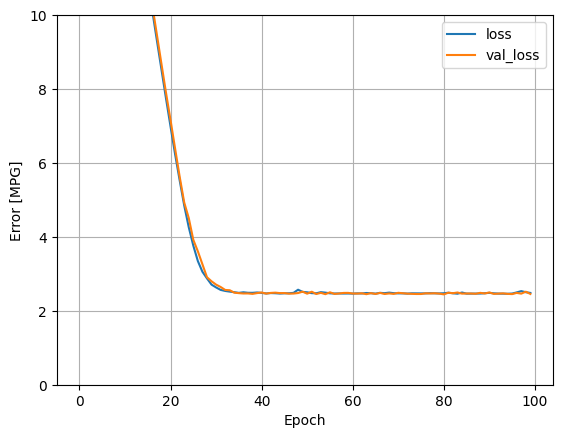

In [11]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.legend()
plt.grid(True)

In [12]:
#show the final weights
linear_model.layers[1].kernel


<Variable path=sequential/dense/kernel, shape=(7, 1), dtype=float32, value=[[-0.394]
 [-0.101]
 [-1.345]
 [-3.266]
 [-0.895]
 [ 2.245]
 [ 1.564]]>

In [13]:
#show the valued for x_norm[1]
print('X_norm[1]:', X_norm(np.array(X[1:2])).numpy())
print('Predicted:', linear_model.predict(X[1:2]).flatten())
print('Actual:', y[1:2].values)

#multiply X_norm(np.array(X[1:2])).numpy() by linear_model.predict(X[1:2]).flatten()
# to get the prediction
print('Prediction By Hand:', np.dot(X_norm(np.array(X[1:2])).numpy(), linear_model.layers[1].kernel.numpy().flatten()) + linear_model.layers[1].bias.numpy())



X_norm[1]: [[ 1.486  1.485  1.581  0.834 -1.458 -1.607 -0.717]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted: [13.997]
Actual: [15.]
Prediction By Hand: [13.997]


In [14]:
#evaluate the model using the test set
test_results = {}
test_results['linear_model'] = linear_model.evaluate(
    X_test,
    y_test, verbose=0)

#total mean squared error
test_results


{'linear_model': 2.4712018966674805}

## DEEP Nueral Network
The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

The normalization layer, as before (with horsepower_normalizer for a single-input model and normalizer for a multiple-input model).
Two hidden, non-linear, Dense layers with the ReLU (relu) activation function nonlinearity.
A linear Dense single-output layer.
Both models will use the same training procedure, so the compile method is included in the build_and_compile_model function below.

In [15]:
deepmodel = keras.Sequential([
      X_norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

deepmodel.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

In [16]:
historydeep = deepmodel.fit(
    X_train,
    y_train,
    validation_split=0.2,
    verbose=0, epochs=100)

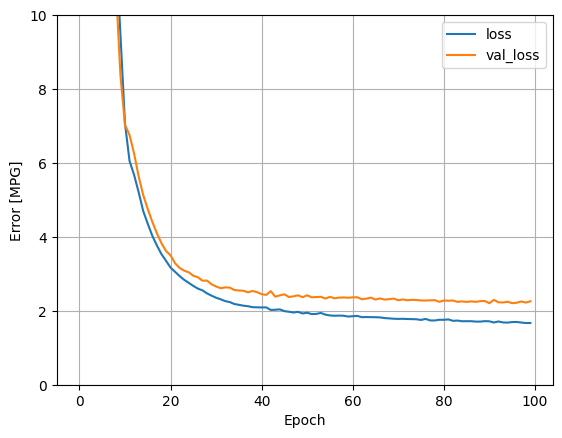

In [17]:
plt.plot(historydeep.history['loss'], label='loss')
plt.plot(historydeep.history['val_loss'], label='val_loss')
plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.legend()
plt.grid(True)

GitHub Copilot: In the context of training a machine learning model, particularly in TensorFlow or Keras, `loss` and `val_loss` refer to the training loss and validation loss, respectively. Here's the difference:

1. **`loss` (Training Loss)**:
   - This is the loss calculated on the training dataset during each epoch.
   - It measures how well the model is fitting the training data.
   - The training loss is minimized during the training process as the model learns from the training data.

2. **`val_loss` (Validation Loss)**:
   - This is the loss calculated on the validation dataset during each epoch.
   - The validation dataset is a separate portion of the data that the model does not directly learn from during training.
   - It provides an estimate of how well the model generalizes to unseen data.
   - A significant gap between `loss` and `val_loss` (e.g., `val_loss` being much higher) can indicate overfitting, where the model performs well on the training data but poorly on unseen data.

### Example:
During training, you might see output like this:
```
Epoch 1/10
loss: 0.3456 - val_loss: 0.4567
Epoch 2/10
loss: 0.1234 - val_loss: 0.2345
```

- `loss` decreases as the model learns from the training data.
- `val_loss` indicates how well the model is performing on the validation data. If `val_loss` starts increasing while `loss` continues to decrease, it may be a sign of overfitting.

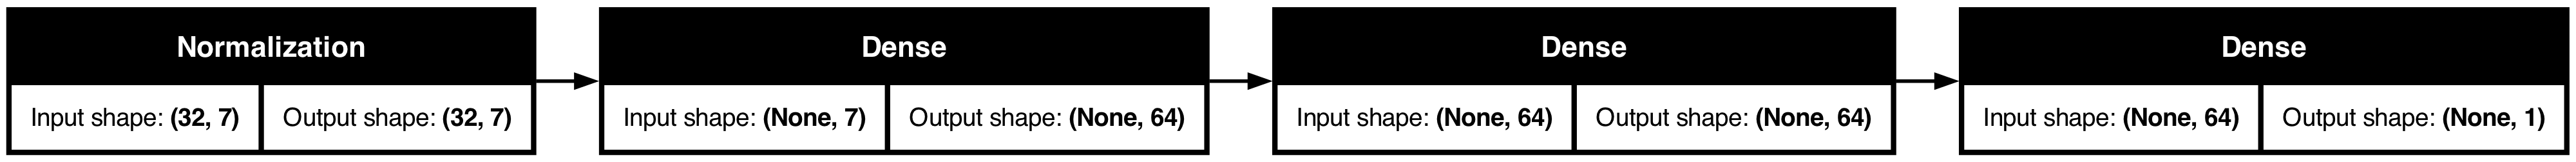

In [18]:
#visualize the model network
keras.utils.plot_model(deepmodel, show_shapes=True, rankdir='LR')



The important thing to look at is the 2nd value of the shape, thats the size of the tensor/array.

So for this output:
- The intial input is of size 7, thats the 7 columns of the Auto dataset we are using
- For the 1st hidden layer (DENSE), the input is of size 7, there are 64 hidden nodes, the outpud will be of size 64
- For the 2nd hidden layer (DENSE), the input is of size 64, there are 64 hidden nodes, the output is of size 64
- The final layer takes 64 inputs and outputs a single scalar value, the prediction for that observation


In [19]:
#make a prediciton using one example from the test set
print('Prediction:', deepmodel.predict(X_test[:1]))
print('Actual:', y_test[:1].values)

#evaluate the model using the test set
test_results['deep_model'] = deepmodel.evaluate(
    X_test,
    y_test, verbose=0)

# print the mse results
test_results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction: [[15.846]]
Actual: [15.]


{'linear_model': 2.4712018966674805, 'deep_model': 1.8108422756195068}